In [1]:
import tensorflow.compat.v2 as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from emnist import extract_test_samples
from emnist import extract_training_samples
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## Load and preprocess training and testing dataset

In [2]:
# Import training and testing dataset

img_rows = 28
img_cols = 28
num_classes = 26
input_shape = (img_rows, img_cols, 1)
filter_x = 5
filter_y = 5

train_images, train_labels = extract_training_samples('letters')
test_images, test_labels = extract_test_samples('letters')

# Make class numbering start at 0
train_labels = train_labels - 1
test_labels = test_labels - 1

In [3]:
# Dataset preprocessing #1

# Reshape 
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1) 
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1) 

# Transfer to nparray
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_labels = to_categorical(train_labels, num_classes, dtype = 'float32')
test_labels = to_categorical(test_labels, num_classes, dtype = 'float32')

In [4]:
# Dataset preprocessing #2(continue)

# Normalize
def thinning(image):
    tmp = np.where(image < 210.0, 0, image)
    return np.where(image < 210.0, 0, 255)

train_images = thinning(train_images)
train_images = (train_images - 128.0) / 128.0

test_images = thinning(test_images)
test_images = (test_images - 128.0) / 128.0

## Model create

In [5]:
# Model create #1

model=Sequential()
#Conv1
model.add(Conv2D(filters=16, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same",  
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#Conv2
model.add(Conv2D(filters=32, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same", 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#Conv3
model.add(Conv2D(filters=32, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same", 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

In [6]:
# Model create #2(continue)

#FC1
model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))

#FC2
model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [7]:
# Show your model

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 32)        0

## Model training

In [8]:
# Training model

#Define optimizer loss function and merics 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set training
model.fit(train_images,train_labels,
          validation_split = 0.2,
          batch_size = 200,
          verbose = 1,
          epochs = 2
          )

Epoch 1/2
500/500 [==============================] - 111s 222ms/step - loss: 0.6879 - accuracy: 0.8233 - val_loss: 0.3709 - val_accuracy: 0.8846
Epoch 2/2
500/500 [==============================] - 106s 212ms/step - loss: 0.2636 - accuracy: 0.9157 - val_loss: 0.2790 - val_accuracy: 0.9102


In [9]:
# Model Evaluation
score = model.evaluate(test_images, test_labels, verbose = 0)

print('test loss', score[0])
print('accuracy', score[1])


test loss 0.2769678235054016
accuracy 0.9100480675697327


In [10]:
# Save weights of this model
model.save_weights('my_model.h5')

In [11]:
#load weights to this TensorFlow model
model.load_weights('my_model.h5')

---------------------------------------------------------------------------------------------------------------------




## Reload and preprocess images

In [12]:
train_images, train_labels = extract_training_samples('letters')
test_images, test_labels = extract_test_samples('letters')

# Make class numbering start at 0
train_labels = train_labels - 1
test_labels = test_labels - 1

## Preprocessing

In [13]:
preprocessed_test_images = test_images.reshape([test_images.shape[0], img_rows, img_cols, 1])

def thinning(image):
    return np.where(image < 210.0, 0, 255)


preprocessed_test_images = thinning(preprocessed_test_images)

preprocessed_test_images = (preprocessed_test_images - 128.0) / 128.0


## Convert model into TFLM format

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [15]:
preprocessed_test_images = tf.cast(preprocessed_test_images, tf.float32)
emnist_ds = tf.data.Dataset.from_tensor_slices((preprocessed_test_images)).batch(1) #construct a dataset 

def representative_data_gen():
    for input_value in emnist_ds.take(100):
        yield [input_value]
    
converter.representative_dataset = representative_data_gen

## Convert the model to TensorFlow Lite format and save it to a file:

In [16]:
import pathlib

converted_model = converter.convert()

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"emnist_model_int8.tflite"
converted_model_file.write_bytes(converted_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\williet\AppData\Local\Temp\tmp0pssdxl0\assets


67696

In order to integrate converted model into TFLM application we have to save it as a C array. One way to do that is to use **xxd** utility available on Linux or in Cygwin/MinGW terminals on Windows. Open terminal and run following commands:

```
cd generated/
xxd -i emnist_model_int8.tflite > model.h
```

The model is ready to be integrated into TFLM application.

## Create a test set for target application

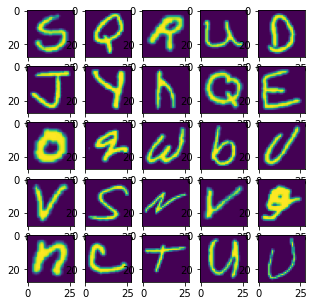

In [17]:
import random

train_images, train_labels = extract_training_samples('letters')
test_images, test_labels = extract_test_samples('letters')

# Make class numbering start at 0
train_labels = train_labels - 1
test_labels = test_labels - 1

num_of_samples = 25
random_test_images = random.sample(range(1, test_images.shape[0]), num_of_samples)

fig=plt.figure(figsize=(5, 5))
cols = 5
rows = 5

for plt_idx, img_idx in enumerate(random_test_images, 1):
    img = test_images[img_idx]
    fig.add_subplot(rows, cols, plt_idx)
    plt.imshow(img)
plt.show()

In [18]:
samples_file = open("generated/test_samples.cc", "w")

samples_file.write("#include \"test_samples.h\"\n\n")
samples_file.write("const int kNumSamples = " + str(num_of_samples) + ";\n\n")

samples = "" 
samples_array = "const TestSample test_samples[kNumSamples] = {"

for sample_idx, img_idx in enumerate(random_test_images, 1):
    img_arr = list(np.ndarray.flatten(test_images[img_idx]))
    var_name = "sample" + str(sample_idx)
    samples += "TestSample " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
    samples += "\t.label = " + str(test_labels[img_idx]) + ",\n" 
    samples += "\t.image = {\n"
    wrapped_arr = [img_arr[i:i + 20] for i in range(0, len(img_arr), 20)]
    for sub_arr in wrapped_arr:
        samples += "\t\t" + str(sub_arr)
    samples += "\t}\n};\n\n"    
    samples_array += var_name + ", "
    
samples = samples.replace("[", "")
samples = samples.replace("]", ",\n")
samples_array += "};\n"

samples_file.write(samples);
samples_file.write(samples_array);
samples_file.close()

## Done

You have converted a Tensorflow model into TFLM format and generated a test set for the application. Now you can copy generated files into target application of this tutorial and try it out:

In order to integrate converted model into TFLM application we have to save it as a C array. One way to do that is to use **xxd** utility available on Linux or in Cygwin/MinGW terminals on Windows. Open terminal and run following commands:

```
cd generated/
xxd -i emnist_model_int8.tflite > model.h
```

The model is ready to be integrated into TFLM application.

* copy *generated/model.h* to *../inc* and *generated/test_samples.cc* to *../src*
* You can start to integrate your WE-I project

## Evaluate TensorFlow Lite Model

Full test set contains 20800 samples. Evaluating int8 model on it might take more than 10 minutes. 
If you want to get estimation faster, please, limit number of samples to be evaluated by reducing **max_samples** value

In [19]:
max_samples = 200

In [20]:
interpreter = tf.lite.Interpreter(model_path=str(converted_model_file))
interpreter.allocate_tensors()

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_output_details()[0]['quantization']

    prediction_values = []
    
    for test_image in preprocessed_test_images[:max_samples]:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0) #.astype(np.float32)
        test_image = np.int8(test_image / scale + zero_point)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
        result = np.argmax(output()[0])
        prediction_values.append(result)
    
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100



Please, keep in mind that full test dataset evaluation on int8 model may take several minutes. 

In [21]:
print(str(evaluate_model(interpreter)) + "%")

97.0%
